# Fundamentals of Data Science - Sentiment Analysis on twitter Data

## Import Data set

In [1]:
import pandas as pd
from pprint import pprint
#pd.set_option('display.max_colwidth', -1)

In [2]:
import json
S_DIR = r'C:\Users\ruche\Downloads\geotagged_tweets_20160812-0912.1000.jsons'

tweets_data = []
tweets_file = open(S_DIR, "r")

for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
# This creates a python list of strings with json data in the string.  

In [3]:
# Print the keys of the dataset collected from one tweet 
# This gives an overview of what information is in the dataset
print(tweets_data[0].keys())

len(tweets_data)
#inspect the keys that may be necessary for sentiment analysis. Essentially the tweet is the most important part

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'entities', 'extended_entities', 'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang', 'timestamp_ms'])


1000

In [4]:
import re

# A function that extracts the hyperlinks from the tweet's content.
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# A function that checks whether a word is included in the tweet's content
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [23]:
tweets = pd.DataFrame()

tweets['text'] =    list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] =    list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data))
tweets['state_full'] = list(map(lambda tweet: tweet['place']['full_name'] if tweet['place'] != None else None, tweets_data))
tweets['state'] = list(map(lambda tweet: tweet['place']['name'] if tweet['place'] != None else None, tweets_data))
tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

## Pre-processing 

In [6]:
# create an empty list for the text that has been "cleaned"
list_clean_text = []

for i in tweets["text"]:
    # this removes the hyperlink
    result = re.sub(r"http\S+", "", i)
    # this removes the people the text was directed to e.g. @HillaryClinton or @CNN
    result2 = re.sub(r"\B@\S+.", "", result)
    result3 = re.sub(r"\d+.", "", result2)
    list_clean_text.append(result3)

# make a new column with the clean text
tweets["clean_text"] = list_clean_text

In [7]:
#Lexicon Normalization
#performing stemming and Lemmatization
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))
stop.update(set(["n", "u", "im"]))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# This is the clean corpus.
doc_clean = [clean(doc) for doc in list_clean_text] 
            

In [8]:
from nltk.tokenize import RegexpTokenizer
import html.parser as HTMLParser# In Python 3.4+ import html 
import nltk

# Tokenize each clean text
tokenized_tweets = []
tokenizer = RegexpTokenizer(r'\w+')
for i in doc_clean:
    tokens = tokenizer.tokenize(i)
    tokenized_tweets.append(tokens)

tweets["tokens"] = tokenized_tweets
# flatten the list of lists to combine all words in one list
flattened_list_of_tokens = [y for x in tokenized_tweets for y in x]

In [9]:
# this function extracts features from text
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return (wordlist, word_features)

# view most common features
word_features = get_word_features(flattened_list_of_tokens)
word_features[0].most_common(10)

# Frequency Distribution Plot
import matplotlib.pyplot as plt
word_features[0].plot(30,cumulative=False)
plt.show()

<Figure size 640x480 with 1 Axes>

## Training the Model

In [10]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

# A function that extracts which words exist in a text based on a list of words to which we compare.
def word_feats(words):
        return dict([(word, True) for word in words])

# Get the negative reviews for movies    
negids = movie_reviews.fileids('neg')

# Get the positive reviews for movies
posids = movie_reviews.fileids('pos')
# Find the features that most correspond to negative reviews    
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
# Find the features that most correspond to positive reviews
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

# We would only use 1500 instances to train on. The quarter of the reviews left is for testing purposes.
negcutoff = int(len(negfeats)*3/4)
poscutoff = int(len(posfeats)*3/4)

In [11]:
from pprint import pprint
# Construct the training dataset containing 50% positive reviews and 50% negative reviews
trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]

# Construct the negative dataset containing 50% positive reviews and 50% negative reviews
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]

print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

# Train a NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(trainfeats)

# Test the trained classifier and display the most informative features.
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

# See most informative features of the model 
#print (classifier.show_most_informative_features(32))

train on 1500 instances, test on 500 instances
accuracy: 0.728


## Testing the model on the tweets dataset

In [12]:
# A list of the classifications
classification = []

# classify each token as positive or negative
for i in tweets["tokens"]:
    classification.append(classifier.classify(word_feats(i)))
    
# make a column of the sentiment/classification of the tweet according to the model
tweets["classification"] = classification
tweets

,text,lang,country,state,link,clean_text,tokens,classification
0,@HillaryClinton @POTUS @JudgeJeanine @NBA @NFL...,en,United States,"Evansville, IN",https://t.co/UDsJmesa5w,There IS A PLAN U PIC ❤️✝👀,"[plan, pic]",neg
1,IF THEY ONLY HAD A BRAIN! \n#NeverTrump #BuhBy...,en,United States,"Nutley, NJ",https://t.co/YjYABvQ8pw,IF THEY ONLY HAD A BRAIN! \n#NeverTrump #BuhBy...,"[brain, nevertrump, buhbyetrump, trumpisunfit]",neg
2,Attorney's first line of defense to those they...,en,United States,"Oklahoma City, OK",,Attorney's first line of defense to those they...,"[attorney, first, line, defense, represent, ke...",pos
3,@kikesma @norma22flores @EPN @realDonaldTrump ...,es,México,"Villaldama, Nuevo León",,No lo recibió como presidente,"[lo, recibió, como, presidente]",pos
4,Classy.. Better than I expected. But on a se...,en,United States,"Marblehead, MA",https://t.co/jOdETLmkSn,Classy.. Better than I expected. But on a se...,"[classy, better, expected, serious, note, woul...",pos
5,@realDonaldTrump I wouldn't even consider it w...,en,United States,"Stevenson Ranch, CA",,I wouldn't even consider it when it is a conso...,"[even, consider, consolation, dinner, you]",neg
6,Join me again @CNN @ThisHour 11:45am re #Trump...,en,United States,"Washington, DC",,"Join me again m re #Trump's dumb ""bigot"" comme...","[join, trump, dumb, bigot, comment, projecting...",pos
7,More fraud from soros and Clinton https://t.co...,en,United States,"Los Alamitos, CA",https://t.co/cjHD1eqW6U,More fraud from soros and Clinton,"[fraud, soros, clinton]",pos
8,Right! @realDonaldTrump thinks he's special‼️ ...,en,United States,"Washington, USA",https://t.co/pHMrEcs1Hj,Right! thinks he's special‼️,"[right, think, he, special]",pos
9,@JohnKStahlUSA I want @realDonaldTrump to say ...,en,United States,"Houston, TX",,I want to say that he will prosecute her and a...,"[want, say, prosecute, crime, usa, including, ...",pos


## Perform sentiment analysis with textblob

In [13]:
from textblob import TextBlob as tb

tweets['sentiment'] = tweets['tokens'].apply(lambda x: tb(" ".join(x)).sentiment[0] )
#tweets[['text','calc_sentiment']]

tweets

,text,lang,country,state,link,clean_text,tokens,classification,sentiment
0,@HillaryClinton @POTUS @JudgeJeanine @NBA @NFL...,en,United States,"Evansville, IN",https://t.co/UDsJmesa5w,There IS A PLAN U PIC ❤️✝👀,"[plan, pic]",neg,0.000000
1,IF THEY ONLY HAD A BRAIN! \n#NeverTrump #BuhBy...,en,United States,"Nutley, NJ",https://t.co/YjYABvQ8pw,IF THEY ONLY HAD A BRAIN! \n#NeverTrump #BuhBy...,"[brain, nevertrump, buhbyetrump, trumpisunfit]",neg,0.000000
2,Attorney's first line of defense to those they...,en,United States,"Oklahoma City, OK",,Attorney's first line of defense to those they...,"[attorney, first, line, defense, represent, ke...",pos,0.250000
3,@kikesma @norma22flores @EPN @realDonaldTrump ...,es,México,"Villaldama, Nuevo León",,No lo recibió como presidente,"[lo, recibió, como, presidente]",pos,0.000000
4,Classy.. Better than I expected. But on a se...,en,United States,"Marblehead, MA",https://t.co/jOdETLmkSn,Classy.. Better than I expected. But on a se...,"[classy, better, expected, serious, note, woul...",pos,-0.086667
5,@realDonaldTrump I wouldn't even consider it w...,en,United States,"Stevenson Ranch, CA",,I wouldn't even consider it when it is a conso...,"[even, consider, consolation, dinner, you]",neg,0.000000
6,Join me again @CNN @ThisHour 11:45am re #Trump...,en,United States,"Washington, DC",,"Join me again m re #Trump's dumb ""bigot"" comme...","[join, trump, dumb, bigot, comment, projecting...",pos,-0.187500
7,More fraud from soros and Clinton https://t.co...,en,United States,"Los Alamitos, CA",https://t.co/cjHD1eqW6U,More fraud from soros and Clinton,"[fraud, soros, clinton]",pos,0.000000
8,Right! @realDonaldTrump thinks he's special‼️ ...,en,United States,"Washington, USA",https://t.co/pHMrEcs1Hj,Right! thinks he's special‼️,"[right, think, he, special]",pos,0.321429
9,@JohnKStahlUSA I want @realDonaldTrump to say ...,en,United States,"Houston, TX",,I want to say that he will prosecute her and a...,"[want, say, prosecute, crime, usa, including, ...",pos,0.000000


In [14]:
# compare the model from nltk with textblob
index = 0
counter_different_classif = 0
counter_neutral = 0
comparison = []
for classification in tweets["classification"]:
   # print(tweets["sentiment"][index])
    if classification == "neg" and tweets["sentiment"][index] < 0:
        comparison.append("same negative")
    elif classification == "neg" and tweets["sentiment"][index] > 0:
        comparison.append("different neg : pos")
        counter_different_classif = counter_different_classif + 1
    elif classification == "pos" and tweets["sentiment"][index] > 0:
        comparison.append("same positive")
    elif classification == "pos" and tweets["sentiment"][index] < 0:
        comparison.append("different pos : neg")
        counter_different_classif = counter_different_classif + 1
    else:
        comparison.append("different neutral")
        counter_neutral = counter_neutral + 1
    index = index + 1
tweets["comparison"] = comparison
print(f"Out of {len(tweets)} tweets, the models had a different classification {counter_different_classif} times")
print(f"Out of {len(tweets)} tweets, textblob found {counter_neutral} neutral tweets")

Out of 1000 tweets, the models had a different classification 181 times
Out of 1000 tweets, textblob found 534 neutral tweets


In [15]:
pos_words = []
neg_words = []
index = 0
for i in tweets["classification"]:
    if i == "pos":
        pos_words.append(tweets["tokens"][index])
    else:
        neg_words.append(tweets["tokens"][index])
    index = index + 1

def flatten(a_list):
    flattened_list = [y for x in a_list for y in x]
    return flattened_list

all_pos_words = flatten(pos_words)
all_neg_words = flatten(neg_words)

In [16]:
from wordcloud import WordCloud

def word_cloud(tweets):
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, max_words=100).generate(tweets)

    # plot the wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show() 

### Positive

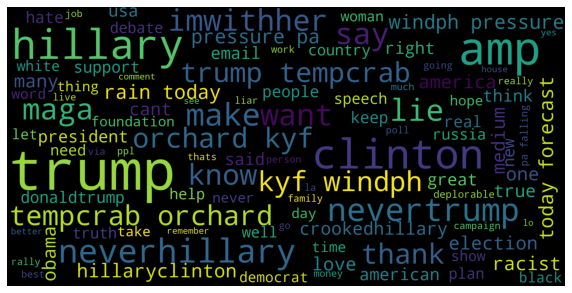

In [17]:
word_cloud(" ".join(all_pos_words))

### Negative words

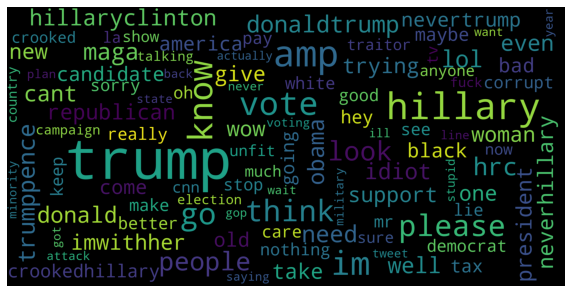

In [18]:
word_cloud(" ".join(all_neg_words))

## Sentiment Per State

In [24]:
tweets.groupby(["state"]).count()

,text,lang,country,state_full,link
state,,,,,
73rd & Central Park West,1,1,1,1,1
Abingdon,1,1,1,1,1
Acacia Villas,2,2,2,2,2
Acworth,1,1,1,1,1
Alabama,2,2,2,2,2
Alafaya,2,2,2,2,2
Albuquerque,1,1,1,1,1
Allen,1,1,1,1,1
Amelia,1,1,1,1,1
